# Kaggle Car Speed Competition Using Optical Flow

## Introduction and Definitions

From what we have learned, optical flow is the pattern of apparent motion of objects, surfaces, and edges in a visual scene caused by the relative motion between an observer and a scene.  In this notebook we demonstrate how optical flow can be used in a real world application where we predict the speed of a car using only dashcam footage while it is driving!  We are able to do this by measuring the relative change between successive frames that the dashcam video captures and using this as input to a CNN.  

## Part 1: Dataset Exploration and Preparation

For this notebook we are attempting to create a solution for a kaggle dataset that is given at the following link:
https://github.com/commaai/speedchallenge/tree/master/data

In this Kaggle dataset we are only given 3 items which are:
1. A video called train.mp4 which has 20400 frames of a car driving around a city
2. A txt file called train.txt which has 20400 columns which gives the speed of the car in mph at the same time as the dashcam captured the video frame
3. A video called test.mp4 which has 10,798 frames of a car driving around a city

Since we are given a training set that has labels we know that this is a supervised learning problem.  However, one thing that we have run into is that we haven't been able to find a test.txt file anywhere even though the competition is over.  Thus it isn't as easy as usual to directly get a test accuracy to tell exactly how well our model is doing on anything except the validation set (which we create from a portion of the training set)! 

### First in our EDA we will simply visualize the train.txt file in order to see what the actual speed of the car is like in our test set:

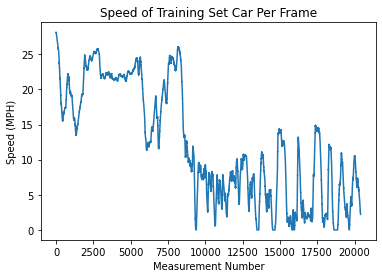

In [11]:
import cv2
import os,time,sys,shutil
import numpy as np
import matplotlib.pyplot as plt

trainLabelsPath = './data/train.txt'
f = open(trainLabelsPath, "r")
allSpeeds = []
for x in f:
    currSpeed = x[:-2]        #removing the '\n at the end of each string before converting to float!'
    currSpeed = float(currSpeed)
    allSpeeds.append(currSpeed)
    
#print(allSpeeds)
plt.plot(allSpeeds)
plt.xlabel("Measurement Number")
plt.ylabel("Speed (MPH)")
plt.title("Speed of Training Set Car Per Frame")
plt.show()

From this we can see that the car appears to be going a lot faster on average at the beginning of the video (perhaps signifying it is on a highway or main road) than towards the latter point.  Also there appears to be a lot of sharp stop-and-go accelerations of the car towards the end perhaps indicating that it is in a neighborhood.  In our last report we are hoping to investigate a bit more whether our optical flow model performed better when speeds were high or low, and also when accelerations were high or low!

### Next we will visualize a few images from both the training and testing videos in order to see if we see anything surprising:
Note that in doing this we first will have to use openCV in order to transform each of these videos into sets of images!  We used the following helper file to break down the mp4 files into 2 additional data folders which were:
1. train_images (containing 20400 dashboard images for training set)
2. test_images  (containing 10798 dashboard images for the testing set)

This took nearly 30 minutes to run because there are so many images so we have commented it out (it was only necessary to run once in a python helper file so we don't need to do this process again in jupyter when we have already created the necessary files locally)

In [ ]:
'''
import cv2
import os, time, sys, shutil

PATH_TRAIN_LABEL = PATH_DATA_FOLDER +  './data/train.txt'
PATH_TRAIN_VIDEO = PATH_DATA_FOLDER + './data/train.mp4'
PATH_TRAIN_IMAGES_FOLDER = PATH_DATA_FOLDER +  './data/train_images/'

PATH_TEST_LABEL = PATH_DATA_FOLDER +  './data/test.txt'
PATH_TEST_VIDEO = PATH_DATA_FOLDER + './data/test.mp4'
PATH_TEST_IMAGES_FOLDER = PATH_DATA_FOLDER +  './data/test_images/'

def convert_data(video_input_path, image_folder_path):

    if os.path.exists(image_folder_path):
        shutil.rmtree(image_folder_path)
    os.makedirs(image_folder_path)

    print("Converting video to frames: ", video_input_path)
    t1 = time.time()

    video_reader = cv2.VideoCapture(video_input_path)
    num_frames = video_reader.get(cv2.CAP_PROP_FRAME_COUNT)

    count = 0
    while True:
        ret, next_frame = video_reader.read()
        if ret is False:
            break

        image_path_out = os.path.join(image_folder_path, str(count) + '.jpg')
        cv2.imwrite(image_path_out, next_frame)

        count += 1
        sys.stdout.write('\rprocessed frames: %d of %d' % (count, num_frames))


    t2 = time.time()
    video_reader.release()
    print(' Conversion completed !')
    print(' Time Taken:', (t2 - t1), 'seconds')
    return

if __name__ == '__main__':
    

    convert_data(PATH_TRAIN_VIDEO, PATH_TRAIN_IMAGES_FOLDER)
    convert_data(PATH_TEST_VIDEO, PATH_TEST_IMAGES_FOLDER)

Below we visualize a few of the images from both the training and testing dataset.  Between each image we skip 5 images ahead to make it more apparent that they are being taken from inside a moving car.  Looking back to our speed graph above we can see that our hypothesis of the car being on a faster road like a highway has been confirmed for the training set! We can also see that the scenery changes when we go to the testing set which makes sense that we would want our algorithm to generalize to any car in any environment!

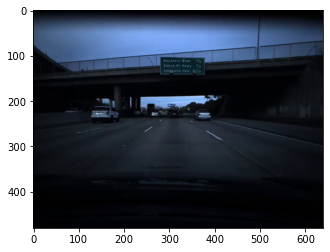

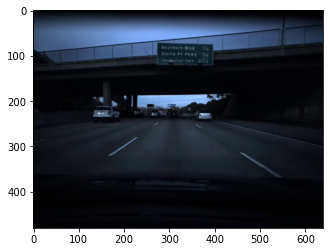

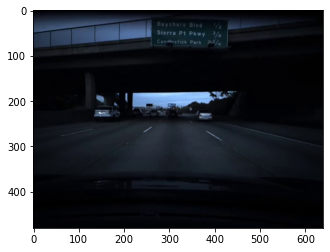

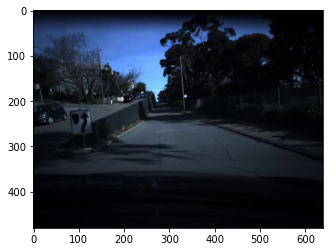

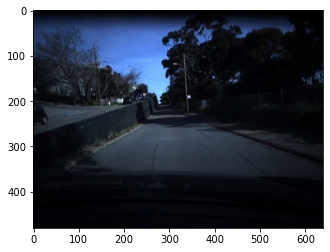

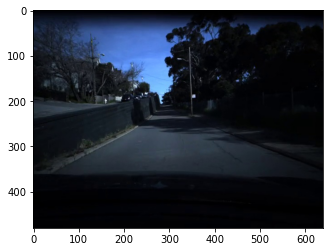

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('./data/train_images/0.jpg')
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread('./data/train_images/5.jpg')
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread('./data/train_images/10.jpg')
imgplot = plt.imshow(img)
plt.show()


#TESTING SET
img = mpimg.imread('./data/test_images/0.jpg')
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread('./data/test_images/5.jpg')
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread('./data/test_images/10.jpg')
imgplot = plt.imshow(img)
plt.show()



One other thing we have noticed is that the images are pretty dark and because of this objects are not very well defined.  Below we quickly show how we can use cv2 to get edge detection (using the Canny feature) which might be helpful in a later implementation when we are really going for maximum accuracy (in this implementation we just stick with the raw images we have been given)

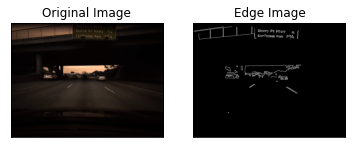

In [41]:
import cv2 as cv
img = cv.imread('./data/train_images/11.jpg')
edges = cv.Canny(img,100,200)
plt.subplot(121)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image')
plt.xticks([])
plt.yticks([])
plt.show()


## Part 2: Building and Training CNN Model
Below we make a basic definition for a generic CNN model as we have done many times before in this class.  Also note that we decide to use 'ELU' as our activation function after reading this paper in order to try something new: https://www.machinecurve.com/index.php/2019/12/09/how-to-use-elu-with-keras/
Also according to this paper the "Exponential Linear Unit" isn't very sensitive to vanishing gradients removing the dying ReLU problem and the mean ELU activation is closer to zero making it learn faster --> meaning less epochs we have to train to get good results!

In [1]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D, Dropout, Reshape, BatchNormalization, ELU
from tensorflow.keras.optimizers import Adam


def CNNModel():
    model = Sequential()
    model.add(Convolution2D(24, (5, 5), input_shape = (240, 320, 3), strides=(2, 2), activation ='elu'))
    model.add(Convolution2D(36, (5, 5), strides=(2,2), activation ='elu'))
    model.add(Convolution2D(48, (5, 5), strides=(2,2), activation ='elu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), strides = (1,1), activation ='elu'))
    model.add(Convolution2D(64, (3, 3), strides= (1,1), activation ='elu'))
    model.add(Flatten())
    model.add(Dense(100, activation ='elu'))
    model.add(Dense(50, activation ='elu'))
    model.add(Dense(10, activation ='elu'))
    model.add(Dense(1, activation ='elu'))

    adam = Adam(learning_rate=1e-4)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In this module we define a function called "convertOptical". This takes in 2 consecutive images from the video clips and will use the cv2 function "calcOpticalFlowFarneback" function in order to create a flow_image which describes how the scene/objects in the scene are changing between the two frames! (Objects with more change between the two images will be illuminated more)

In [2]:
import cv2
import numpy as np

def convertOptical(prev_image, curr_image):
    prev_image_gray = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY) #grayscaling both of the input images
    curr_image_gray = cv2.cvtColor(curr_image, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_image_gray, curr_image_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    hsv = np.zeros_like(prev_image)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,1] = 255
    hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    flow_image_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return flow_image_bgr

The following cell is where our CNN model is trained using the training set and labels.  
1. First in our prepareData function we go through the process of creating training pairs of images.  We iteratively go through and pick out the actual speed of the car from the train_labels.  Then we go through and grab the current real image as well as the optical flow images from the previous 4 steps. Note that prior to running this cell we ran the convertOptical cell on every image in the training set using the image before it and saved the results to /train_images_flow so that we could access these results now!

2. We split our training data into 80% training data and 20% validation data.  This step is especially important for problems like this where the test set is not available (because we have to decide how good our model is only using the training set)!

3. We trained for only 2 epochs and a batch size of 128.  We wanted to do longer, but the epochs took so long that we were limited to only doing 2 epochs (also we were having trouble uploading a large amount of data to google colab which would have helped us with the GPU had we been able to get our data loaded onto the drive there). 

Total Images: 20396
Train samples: 16316
Validation samples: 4080
Training model...


<ipython-input-3-867a4bfb2019>:209: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_object = model.fit_generator(training_generator, steps_per_epoch= \


Epoch 1/2
127/127 [==============================] - 1094s 9s/step - loss: 44.5155 - val_loss: 15.6360
Epoch 2/2
127/127 [==============================] - 1034s 8s/step - loss: 11.1546 - val_loss: 6.7194
Training model complete...
dict_keys(['loss', 'val_loss'])
Loss
[44.515472412109375, 11.15462875366211]
Validation Loss
[15.636003494262695, 6.719419956207275]


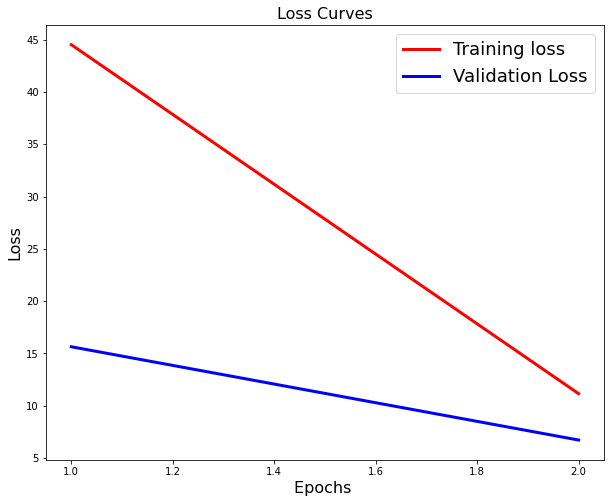

<Figure size 432x288 with 0 Axes>

In [3]:
import cv2
import numpy as np
import os, sys
from os import listdir
from os.path import join
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D, Dropout, Reshape, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image

PATH_DATA_FOLDER = './data/'
PATH_TRAIN_LABEL = PATH_DATA_FOLDER +  'train.txt'
PATH_TRAIN_IMAGES_FOLDER = PATH_DATA_FOLDER +  'train_images/'
PATH_TRAIN_IMAGES_FLOW_FOLDER = PATH_DATA_FOLDER +  'train_images_flow/'

TYPE_FLOW_PRECOMPUTED = 1

BATCH_SIZE = 128
EPOCH = 2

MODEL_NAME = 'CNNModel_flow'
# MODEL_NAME = 'CNNModel_combined'


def prepareData(labels_path, images_path, flow_images_path, type=TYPE_FLOW_PRECOMPUTED):
    num_train_labels = 0
    train_labels = []
    train_images_pair_paths = []

    with open(labels_path) as txt_file:
        labels_string = txt_file.read().split()

        for i in range(4, len(labels_string)):
            speed = float(labels_string[i])
            train_labels.append(speed)

            if type == TYPE_FLOW_PRECOMPUTED:
                
                # Combine original and the 4 previous pre-computed optical flow images
                train_images_pair_paths.append( ( os.getcwd() + images_path[1:] + str(i)+ '.jpg',  os.getcwd() + flow_images_path[1:] + str(i-3) + '.jpg',   os.getcwd() + flow_images_path[1:] + str(i-2) + '.jpg',   os.getcwd() + flow_images_path[1:] + str(i-1) + '.jpg',  os.getcwd() + flow_images_path[1:] + str(i) + '.jpg') )
    return train_images_pair_paths, train_labels


def generatorData(samples, batch_size=128, type=TYPE_FLOW_PRECOMPUTED):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for imagePath, measurement in batch_samples:

                combined_image = None
                flow_image_bgr = None

                if type == TYPE_FLOW_PRECOMPUTED:

                    #curr_image_path, flow_image_path = imagePath
                    #flow_image_bgr = cv2.imread(flow_image_path)
                    #print(imagePath)
                    curr_image_path, flow_image_path1, flow_image_path2,flow_image_path3, flow_image_path4 = imagePath
                    im1, im2, im3, im4 = cv2.imread(flow_image_path1), cv2.imread(flow_image_path2), cv2.imread(
                        flow_image_path3), cv2.imread(flow_image_path4)
                    if im1 is not None and im2 is not None and im3 is not None and im4 is not None:
                        flow_image_bgr = (cv2.imread(flow_image_path1) +cv2.imread(flow_image_path2) +cv2.imread(flow_image_path3) +cv2.imread(flow_image_path4) )/4

                    curr_image = cv2.imread(curr_image_path)
                    if curr_image is not None:
                       curr_image = cv2.cvtColor(curr_image, cv2.COLOR_BGR2RGB)

                else:
                    prev_image_path, curr_image_path = imagePath
                    prev_image = cv2.imread(prev_image_path)
                    curr_image = cv2.imread(curr_image_path)
                    flow_image_bgr = convertOptical(prev_image, curr_image)
                    curr_image = cv2.cvtColor(curr_image, cv2.COLOR_BGR2RGB)


                combined_image = 0.1*curr_image + flow_image_bgr      #0.1 original image and all of the flow image!!
        
                combined_image = cv2.normalize(combined_image, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                combined_image = cv2.resize(combined_image, (0,0), fx=0.5, fy=0.5)

                # im = Image.fromarray(combined_image)
                # plt.imshow(im)
                # plt.show()

                images.append(combined_image)
                angles.append(measurement)

                # AUGMENTING DATA
                # Flipping image, correcting measurement and  measuerement

                images.append(cv2.flip(combined_image,1))
                angles.append(measurement)

            inputs = np.array(images)
            outputs = np.array(angles)
            yield sklearn.utils.shuffle(inputs, outputs)



if __name__ == '__main__':

    type_ = TYPE_FLOW_PRECOMPUTED   ## optical flow pre computed
    train_images_pair_paths, train_labels =  prepareData(PATH_TRAIN_LABEL, PATH_TRAIN_IMAGES_FOLDER, PATH_TRAIN_IMAGES_FLOW_FOLDER, type=type_)

    samples = list(zip(train_images_pair_paths, train_labels))
    train_samples, validation_samples = train_test_split(samples, test_size=0.2)

    print('Total Images: {}'.format( len(train_images_pair_paths)))
    print('Train samples: {}'.format(len(train_samples)))             #contains all of the images in the training set
    print('Validation samples: {}'.format(len(validation_samples)))    #contains all of the images in our random validation set

    training_generator = generatorData(train_samples, batch_size=BATCH_SIZE, type=type_)
    validation_generator = generatorData(validation_samples, batch_size=BATCH_SIZE, type=type_)

    print('Training model...')

    model = CNNModel()
    
    
    #HERE IS WHERE WE WOULD USE EARLY STOPPING IF WE COULD LET THE MODEL RUN AS LONG AS WE WANTED. 
    #WE STILL SAVE OUR MODEL WEIGHTS TO THE NAME 'bestMODEL_NAME.h5' SO THAT WE CAN ACCESS IT BELOW IN TESTING AND 
    #LATER WHEN WE DON'T WANT TO REPEAT TRAINING
    callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best'+MODEL_NAME+'.h5', monitor='val_loss', save_best_only=True)]

    history_object = model.fit_generator(training_generator, steps_per_epoch= \
        len(train_samples) // BATCH_SIZE, validation_data=validation_generator, \
                                         validation_steps=len(validation_samples) // BATCH_SIZE, callbacks=callbacks,
                                         epochs=EPOCH, verbose=1)


    print('Training model complete...')

    print(history_object.history.keys())
    print('Loss')
    print(history_object.history['loss'])
    print('Validation Loss')
    print(history_object.history['val_loss'])


    plt.figure(figsize=[10,8])
    plt.plot(np.arange(1, len(history_object.history['loss'])+1), history_object.history['loss'],'r',linewidth=3.0)
    plt.plot(np.arange(1, len(history_object.history['val_loss'])+1), history_object.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.show()
    plt.savefig('graph.png')


From what we can see above the training and validation loss were still definitely going down so it would have been optimal to do a bunch more epochs (Waiting for the early stopping method provided by Keras to kick in would have been optimal).  However given time constraints we couldn't wait this long.

## Part 3 Testing/Predicting and Visualizing the Model!

In this section we create a new txt file that has the predictions going along with each frame of the testing set.  We also create a video that has our optical flow images and 0.1 of the original picture mixed together.  This is in accordance with how we were creating our training images above (in the future we would like to investigate further with the ratio of how much optical flow to original picture should be used to get the optimal accuracy results!  However for the time being we are happy with our general framework we have come to for training and predicting our model which uses the optical flow of consecutive images to make predictions for the speed of the vehicle at the time! 

Note that in our github we include a short demo video where we show snippets of the final mp4 video file we were able to produce where we show our model's predicted speed for every frame as the test car is travelling down the road!

In [7]:
import cv2
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

PATH_DATA_FOLDER = './data/'
PATH_TEST_LABEL = PATH_DATA_FOLDER +  'test.txt'
PATH_TEST_VIDEO = PATH_DATA_FOLDER + 'test.mp4'
PATH_TEST_VIDEO_OUTPUT = PATH_DATA_FOLDER + 'test_output.mp4'
PATH_COMBINED_TEST_VIDEO_OUTPUT = PATH_DATA_FOLDER + 'combined_test_output.mp4'
PATH_TEST_IMAGES_FOLDER = PATH_DATA_FOLDER +  'test_images/'
PATH_TEST_IMAGES_FLOW_FOLDER = PATH_DATA_FOLDER +  'test_images_flow/'

TYPE_ORIGINAL = 1


MODEL_NAME = 'CNNModel_flow'
# MODEL_NAME = 'CNNModel_combined'

PRE_TRAINED_WEIGHTS = './best'+MODEL_NAME+'.h5'


def predict_from_video(video_input_path, original_video_output_path, combined_video_output_path):
    predicted_labels = []

    video_reader = cv2.VideoCapture(video_input_path)

    num_frames = video_reader.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_size = (int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    fps = int(video_reader.get(cv2.CAP_PROP_FPS))

    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    #fourcc = 0x00000021
    video_writer = cv2.VideoWriter(original_video_output_path, fourcc, fps, frame_size)
    video_writer_combined = cv2.VideoWriter(combined_video_output_path, fourcc, fps, frame_size)

    t1 = time.time()
    ret, prev_frame = video_reader.read()
    hsv = np.zeros_like(prev_frame)

    video_writer.write(prev_frame)

    predicted_labels.append(0.0)

    flow_image_bgr_prev1 =  np.zeros_like(prev_frame)
    flow_image_bgr_prev2 =  np.zeros_like(prev_frame)
    flow_image_bgr_prev3 =  np.zeros_like(prev_frame)
    flow_image_bgr_prev4 =  np.zeros_like(prev_frame)


    font                   = cv2.FONT_HERSHEY_SIMPLEX
    place = (50,50)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    count =0
    while True:
        ret, next_frame = video_reader.read()
        if ret is False:
            break

        flow_image_bgr_next = convertOptical(prev_frame, next_frame)
        flow_image_bgr = (flow_image_bgr_prev1 + flow_image_bgr_prev2 +flow_image_bgr_prev3 +flow_image_bgr_prev4 + flow_image_bgr_next)/4

        curr_image = cv2.cvtColor(next_frame, cv2.COLOR_BGR2RGB)

        combined_image_save = 0.1*curr_image + flow_image_bgr

        #CHOOSE IF WE WANT TO TEST WITH ONLY OPTICAL FLOW OR A COMBINATION OF VIDEO AND OPTICAL FLOW
        combined_image = flow_image_bgr
        # combined_image = combined_image_save

        combined_image_test = cv2.normalize(combined_image, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        # plt.imshow(combined_image)
        # plt.show()

        #CHOOSE IF WE WANT TO TEST WITH ONLY OPTICAL FLOW OR A COMBINATION OF VIDEO AND OPTICAL FLOW
        # combined_image_test = cv2.resize(combined_image, (0,0), fx=0.5, fy=0.5)
        combined_image_test = cv2.resize(combined_image_test, (0,0), fx=0.5, fy=0.5)

        combined_image_test = combined_image_test.reshape(1, combined_image_test.shape[0], combined_image_test.shape[1], combined_image_test.shape[2])

        prediction = model.predict(combined_image_test)

        predicted_labels.append(prediction[0][0])

        # print(combined_image.shape, np.mean(flow_image_bgr), prediction[0][0])

        cv2.putText(next_frame, str(prediction[0][0]), place, font, fontScale,fontColor,lineType)
        cv2.putText(combined_image_save, str(prediction[0][0]), place, font, fontScale,fontColor,lineType)

        video_writer.write(next_frame)
        video_writer_combined.write(combined_image_save.astype('uint8'))

        prev_frame = next_frame
        flow_image_bgr_prev4 = flow_image_bgr_prev3
        flow_image_bgr_prev3 = flow_image_bgr_prev2
        flow_image_bgr_prev2 = flow_image_bgr_prev1
        flow_image_bgr_prev1 = flow_image_bgr_next

        count +=1
        sys.stdout.write('\rprocessed frames: %d of %d' % (count, num_frames))


    t2 = time.time()
    video_reader.release()
    video_writer.release()
    video_writer_combined.release()
    print(' Prediction completed !')
    print(' Time Taken:', (t2 - t1), 'seconds')
    
    print(predicted_labels)
    #predicted_labels[0] = predicted_labels[1]
    return predicted_labels



if __name__ == '__main__':

    model = CNNModel()
    model.load_weights(PRE_TRAINED_WEIGHTS)

    print('Testing model...')
    predicted_labels = predict_from_video(PATH_TEST_VIDEO,  PATH_TEST_VIDEO_OUTPUT, PATH_COMBINED_TEST_VIDEO_OUTPUT)

    with open(PATH_TEST_LABEL, mode="w") as outfile:
        for label in predicted_labels:
            outfile.write("%s\n" % str(label))


Testing model...
processed frames: 10797 of 10798 Prediction completed !
 Time Taken: 1638.1551599502563 seconds
[0.0, 3.681232, 1.9626731, 2.1663165, 3.5629437, 6.4025974, 11.11977, 13.349799, 16.724201, 16.943962, 12.447403, 8.546507, 7.3142796, 5.381951, 7.5262833, 8.571526, 8.87522, 8.913393, 7.367902, 7.0803847, 8.24683, 8.111812, 7.3076105, 5.231603, 5.2601147, 9.48545, 18.084963, 22.239614, 22.264473, 19.913807, 18.636282, 14.952449, 16.635687, 16.91658, 19.83786, 15.57496, 15.100328, 14.175338, 12.100988, 10.47848, 8.861043, 8.319579, 8.391182, 9.686176, 9.772925, 10.427357, 9.44469, 7.9714427, 6.163322, 4.9284606, 5.5631833, 5.230512, 6.3859744, 8.953434, 10.640905, 14.268987, 17.151926, 14.938737, 12.119468, 10.249065, 7.3171134, 6.6033707, 6.7904577, 7.248217, 8.236092, 8.972999, 9.32962, 9.644875, 10.084353, 10.340726, 11.278477, 11.549748, 9.598835, 8.742187, 7.938206, 6.7913785, 6.667559, 7.5064087, 5.2632756, 4.879889, 4.654132, 5.1900616, 6.762997, 8.65414, 8.422428, 8.

### Finally below we visualize the predictions our model has made for each frame of the testing set
Some things to notice is that the predictions are much more jagged (not smooth like our real data in the training set).  This is concerning because usually the speed of vehicles doesn't fluctuate this fast or often!  We imagine that possible with more time/epochs to train some of this may have been eliminated and the curve might look more smooth.  However it is still hard to guage exactly how well this model has done since there is no test set given.  In the next progress report we plan to do further analysis into the validation set we are manually creating to see how well it is doing.

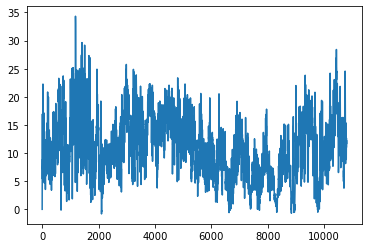

In [42]:
trainLabelsPath = './data/test.txt'
f = open(trainLabelsPath, "r")
allSpeeds = []
for x in f:
    currSpeed = x[:-2]        #removing the '\n at the end of each string before converting to float!'
    currSpeed = float(currSpeed)
    allSpeeds.append(currSpeed)
    
#print(allSpeeds)
plt.plot(allSpeeds)
plt.show()

### Remember to check out the .mp4 video that we have on our github (produced in the cell 2 above here) where we show how we overlayed these predictions on a mixture of the original video and our flow images